_This notebook contains code and comments from Section 4.4 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

---

## Estudio de caso: clasificación de dígitos de escritura a mano
En este estudio de caso, utilizaremos el conjunto de datos de dígitos de scikit-learn para ilustrar la eficacia de AdaBoost. El conjunto de datos consta de 1797 imágenes escaneadas de dígitos escritos a mano del 0 al 9. Cada dígito está asociado con una etiqueta única, lo que hace que este sea un problema de clasificación de 10 clases. Hay aproximadamente 180 dígitos por clase.

Los dígitos en sí mismos se representan como imágenes de mapa de bits en escala de grises normalizadas de 16 x 16, que cuando se aplanan dan como resultado un vector de 64 dimensiones para cada dígito escrito a mano. Así, el conjunto de entrenamiento tiene un tamaño de 1797 (ejemplos) x 64 características.

In [1]:
from sklearn.datasets import load_digits
X, y = load_digits(return_X_y=True)
X.shape

(1797, 64)

In [2]:
import matplotlib.pyplot as plt
import numpy as np

Podemos visualizar este conjunto de datos con una instantánea para tener una idea de cómo se ven.

(-0.5, 79.5, 79.5, -0.5)

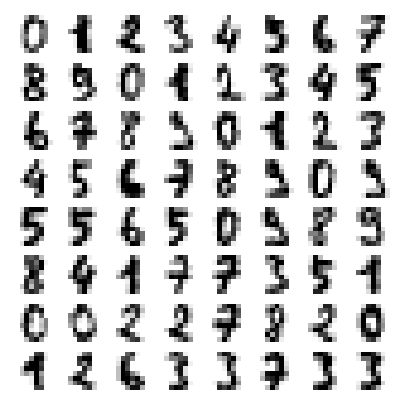

In [3]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

n_img_per_row = 8
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

ax.imshow(img, cmap=plt.cm.binary)
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
# ax.set_title('A selection from the 64-dimensional digits dataset')

# plt.savefig('./figures/CH04_F13_Kunapuli.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0);
# plt.savefig('./figures/CH04_F13_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0);

---
### Reducción de dimensionalidad con t-SNE

Si bien AdaBoost puede manejar de manera efectiva la dimensionalidad del conjunto de datos de dígitos (64 características), buscaremos (bastante agresivamente) reducir la dimensionalidad a 2. La razón principal de esto es poder visualizar los datos, así como los modelos aprendidos por AdaBoost.

Usaremos una técnica de reducción de dimensionalidad no lineal conocida como [vecino estocástico distribuido en t (t-distributed stochastic neighbor)](https://lvdmaaten.github.io/tsne/), incrustación (embedding) o t-SNE. ``t-SNE`` es una técnica de preprocesamiento altamente efectiva para el conjunto de datos de dígitos y extrae una incrustación efectiva en un espacio bidimensional.

En ``scikit-learn``, el paquete [manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) implementa t-SNE.

In [4]:
from sklearn.manifold import TSNE
Xemb = TSNE(n_components=2, init='pca').fit_transform(X)

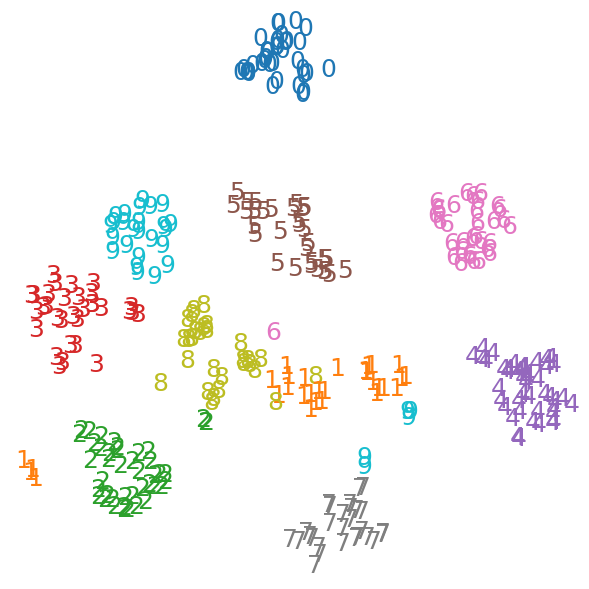

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
xMin, xMax = np.min(Xemb, axis=0), np.max(Xemb, axis=0)
Xemb = (Xemb - xMin) / (xMax - xMin)

for i in range(Xemb.shape[0]):
    if np.random.ranf() < 0.8:
        # Skip some data points so that the image isn't super cluttered
        continue
    plt.text(Xemb[i, 0], Xemb[i, 1], str(y[i]), color=plt.cm.tab10(y[i] / 10.),
             fontdict={'size': 18})

ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')
fig.tight_layout()

# plt.savefig('./figures/CH04_F14_Kunapuli.png', format='png', dpi=300, bbox_inches='tight', pad_inches=0)
# plt.savefig('./figures/CH04_F14_Kunapuli.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0)

Es importante reservar una parte de los datos de entrenamiento para evaluarlos y cuantificar el rendimiento predictivo de nuestros modelos en datos futuros. Dividimos los datos de menor dimensión Xemb y las etiquetas en conjuntos de entrenamiento y prueba.

Observe el uso de ``stratify=y``, para asegurarse de que las proporciones de los diferentes dígitos en el entrenamiento y los conjuntos de prueba sean idénticas.

In [6]:
from sklearn.model_selection import train_test_split
Xtrn, Xtst, ytrn, ytst = train_test_split(Xemb, y, test_size=0.2, stratify=y, random_state=13)

---
### Impulso (Boosting)

Ahora entrenaremos un modelo AdaBoost para esta tarea de clasificación de dígitos. Recuerde de nuestra discusión anterior que AdaBoost requiere que primero decidamos el tipo de estimador base. Seguimos usando tocones (stumps) de decisión.

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

stump = DecisionTreeClassifier(max_depth=2)
ensemble = AdaBoostClassifier(algorithm='SAMME', base_estimator=stump)

Para identificar la mejor combinación de ``índice_de_aprendizaje (Learning rates)`` y ``n_estimadores`` para ``AdaBoostClassifier``, emplearemos una combinación de validación cruzada k-fold y [búsqueda en cuadrícula](https://en.wikipedia.org/wiki/Hyperparameter_optimization#Grid_search).

La idea básica es considerar diferentes combinaciones de ``índice_de_aprendizaje`` y ``n_estimadores`` y evaluar cómo sería su rendimiento a través de la validación cruzada. Primero, seleccionamos varios valores de parámetros que queremos explorar.

In [8]:
parameters_to_search = {'n_estimators': [200, 300, 400, 500],
                        'learning_rate': [0.6, 0.8, 1.0]}

A continuación, creamos una función de puntuación para evaluar el rendimiento de cada combinación de parámetros. Para esta tarea, usamos el puntaje de precisión balanceado, que es esencialmente solo el puntaje de precisión ponderado por cada clase.

In [9]:
from sklearn.metrics import balanced_accuracy_score, make_scorer
scorer = make_scorer(balanced_accuracy_score, greater_is_better=True)

Ahora, configuramos y ejecutamos la búsqueda de cuadrícula para identificar la mejor combinación de parámetros con la clase [``GridSearchCV``](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). El parámetro ``cv=5`` especifica la validación cruzada de 5 veces y ``n_jobs=-1`` especifica que el trabajo debe usar todos los núcleos disponibles para el procesamiento paralelo.

El parámetro final en ``GridSearchCV`` se establece en ``refit=True``. Esto le dice a GridSearchCV que entrene un modelo final usando todos los datos de entrenamiento disponibles usando la mejor combinación de parámetros que haya identificado.

In [10]:
from sklearn.model_selection import GridSearchCV
search = GridSearchCV(ensemble, param_grid=parameters_to_search,
                       scoring=scorer, cv=5, n_jobs=-1, refit=True)
search.fit(Xtrn, ytrn)

c:\Users\lasm1\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(max_depth=2)),
             n_jobs=-1,
             param_grid={'learning_rate': [0.6, 0.8, 1.0],
                         'n_estimators': [200, 300, 400, 500]},
             scoring=make_scorer(balanced_accuracy_score))

In [11]:
best_combo = search.cv_results_['params'][search.best_index_]
best_score = search.best_score_
print('The best parameter settings are {0}, with score = {1}.'.format(best_combo, best_score))

The best parameter settings are {'learning_rate': 1.0, 'n_estimators': 400}, with score = 0.9665464331326401.


El mejor modelo está disponible en ``search.best_estimator_`` y se puede usar para hacer predicciones sobre los datos de prueba.

In [12]:
ypred = search.best_estimator_.predict(Xtst)

¿Qué tan bien le fue a este modelo? Primero podemos ver el informe de clasificación.

In [13]:
from sklearn.metrics import classification_report
print('Classification report:\n{0}\n'.format(classification_report(ytst, ypred)))

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      0.95      0.97        37
           2       1.00      0.89      0.94        35
           3       0.90      0.95      0.92        37
           4       1.00      1.00      1.00        36
           5       0.95      1.00      0.97        36
           6       1.00      1.00      1.00        36
           7       1.00      1.00      1.00        36
           8       0.97      0.94      0.96        35
           9       0.92      1.00      0.96        36

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360




In [14]:
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n {0}".format(confusion_matrix(ytst, ypred)))

Confusion matrix: 
 [[36  0  0  0  0  0  0  0  0  0]
 [ 0 35  0  0  0  0  0  0  1  1]
 [ 0  0 31  4  0  0  0  0  0  0]
 [ 0  0  0 35  0  2  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0]
 [ 0  0  0  0  0 36  0  0  0  0]
 [ 0  0  0  0  0  0 36  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  0  0 33  2]
 [ 0  0  0  0  0  0  0  0  0 36]]


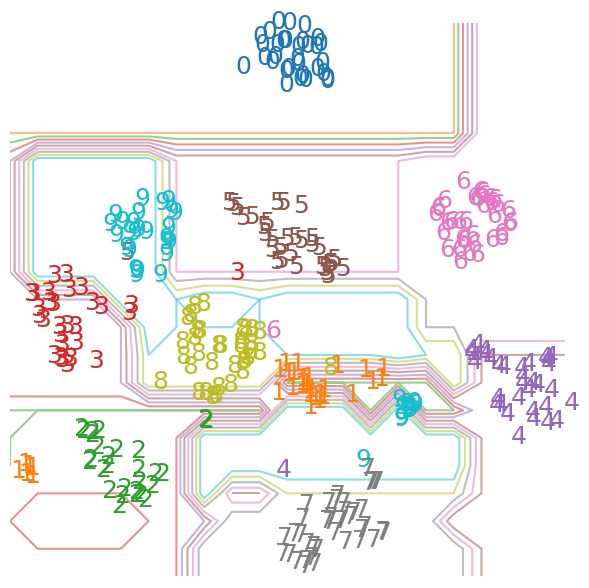

In [15]:
# Visualize the decision boundary
xMin, xMax = Xemb[:, 0].min(), Xemb[:, 0].max() + 0.05
yMin, yMax = Xemb[:, 1].min(), Xemb[:, 1].max() + 0.05
xMesh, yMesh = np.meshgrid(np.arange(xMin, xMax, 0.05),
                           np.arange(yMin, yMax, 0.05))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
zMesh = search.best_estimator_.predict(np.c_[xMesh.ravel(), yMesh.ravel()])
zMesh = zMesh.reshape(xMesh.shape) * 1.0
# boundary = ax.contourf(xMesh, yMesh, zMesh, np.array([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
#                        cmap=plt.cm.tab10, alpha=0.15)
boundary = ax.contour(xMesh, yMesh, zMesh, np.array([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), cmap=plt.cm.tab10, alpha=0.5)
    
for i in range(X.shape[0]):
    if np.random.ranf() < 0.8:
        # Skip some data points so that the image isn't super cluttered
        continue
    plt.text(Xemb[i, 0], Xemb[i, 1], str(y[i]), color=plt.cm.tab10(y[i] / 10.),
             fontdict={'size': 18})

ax.axis('off')
# fig.colorbar(boundary)

fig.tight_layout()
# plt.savefig('./figures/CH04_F15_Kunapuli.png', format='png', dpi=200, bbox_inches='tight', pad_inches=0)
# plt.savefig('./figures/CH04_F15_Kunapuli.pdf', format='pdf', dpi=200, bbox_inches='tight', pad_inches=0)